# Predicting the Sale Price of Bulldozers using Machine Learning

In this notebook, I am going to go through an example of machine learning project with the goal of predicting the sale price of bulldozers

## 1. Problem definition

> How well can we predict the future sale price of a bulldozer, given its characteristics and previous examples of how much similar bulldozers have been sold for?

## 2. Data

The data is downloaded from the Kaggle Bluebook for Bulldozers competition: [Dataset](https://www.kaggle.com/c/bluebook-for-bulldozers/data)

There are 3 main datasets:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012. You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

## 3. Evaluation

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

For more on the evaluation of this project check: [Evaluation information](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation)

**Note**: The goal for most regression evaluation metrics is to minimize the error. For example, our goal for this project will be to build a machine learning model which minimizes RMSLE.

## 4. Features

Kaggle provides a data dictionary detailing all the features of the dataset. You can view this data dictionary on Google Sheets: [Features information](https://docs.google.com/spreadsheets/d/18ly-bLR8sbDJLITkWG7ozKm8l3RyieQ2Fpgix-beSYI/edit?usp=sharing)


In [3]:
# Regular EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For plots to appear inside the notebook
% matplotlib inline

In [4]:
# Import training and validation sets
df = pd.read_csv("data/TrainAndValid.csv", low_memory=False)
df.head(5)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,3/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,5/19/2011 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,7/23/2009 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

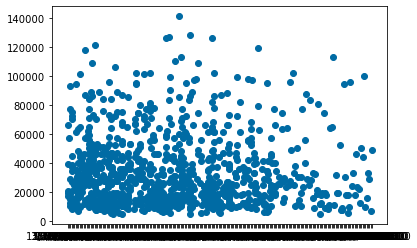

In [6]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000])

<AxesSubplot:ylabel='Frequency'>

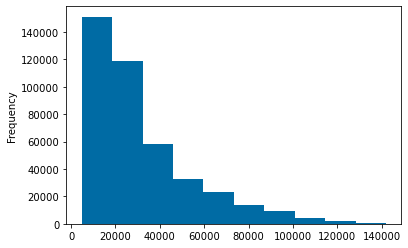

In [7]:
df.SalePrice.plot.hist()

### Persing dates

When we work with time series data, we want to enrich the time & date component as much as possible.

We can do that by telling pandas which of our columns has dates in it using the `parse_dates` parameter.

In [8]:
# Import data again with parsed dates
df = pd.read_csv("data/TrainAndValid.csv", low_memory=False, parse_dates=["saledate"])

In [9]:
df.saledate.dtype

dtype('<M8[ns]')

In [10]:
df.saledate.head()

0   2006-11-16
1   2004-03-26
2   2004-02-26
3   2011-05-19
4   2009-07-23
Name: saledate, dtype: datetime64[ns]

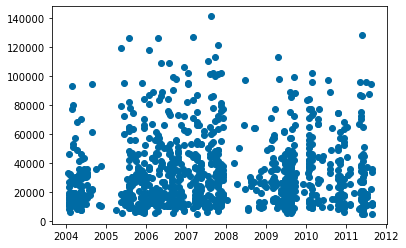

In [11]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000])

In [12]:
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [14]:
df.saledate.head(20)

0    2006-11-16
1    2004-03-26
2    2004-02-26
3    2011-05-19
4    2009-07-23
5    2008-12-18
6    2004-08-26
7    2005-11-17
8    2009-08-27
9    2007-08-09
10   2008-08-21
11   2006-08-24
12   2005-10-20
13   2006-01-26
14   2006-01-03
15   2006-11-16
16   2007-06-14
17   2010-01-28
18   2006-03-09
19   2005-11-17
Name: saledate, dtype: datetime64[ns]

### Sort DataFrame by saledate

When working with time series data, it's a good idea to sort it by date.

In [15]:
# Sort DataFame in date order
df.sort_values(by=["saledate"], inplace=True, ascending=True)
df.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

### Make a copy of the original DataFrame

To prevent damage to the original data

In [17]:
# Make a copy

df_tmp = df.copy()

In [18]:
df_tmp

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410879,6302984,16000.0,1915521,5266,149,99.0,2001,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN
412476,6324811,6000.0,1919104,19330,149,99.0,2004,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
411927,6313029,16000.0,1918416,17244,149,99.0,2004,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
407124,6266251,55000.0,509560,3357,149,99.0,1993,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Add datetime parameters for `saledate` column

In [19]:
df_tmp["saleYear"] = df_tmp.saledate.dt.year
df_tmp["saleDay"] = df_tmp.saledate.dt.day
df_tmp["saleMonth"] = df_tmp.saledate.dt.month
df_tmp["saleDayOfWeek"] = df_tmp.saledate.dt.dayofweek
df_tmp["saleDayOfYear"] = df_tmp.saledate.dt.dayofyear

In [23]:
df_tmp.head(20).T

,205615,274835,141296,212552,62755,54653,81383,204924,135376,113390,113394,116419,32138,127610,76171,127000,128130,127626,55455,55454
SalesID,1646770,1821514,1505138,1671174,1329056,1301884,1379228,1645390,1493279,1449549,1449555,1453775,1264985,1475641,1364654,1474844,1476264,1475662,1305337,1305336
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0,23500.0,31000.0,11750.0,63000.0,13000.0,10500.0,20000.0,20000.0,23500.0,14000.0,11250.0,29000.0,22000.0,17000.0,17000.0
MachineID,1126363,1194089,1473654,1327630,1336053,1182999,1082797,1527216,1363756,1289412,1102310,1514650,1204499,1194367,1270628,1279993,1245504,1242833,1517075,1236263
ModelID,8434,10150,4139,8591,4089,4123,7620,8202,2759,3356,3356,7008,6788,7277,7289,7257,7277,7277,3356,3356
datasource,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984,1976,1986,1970,1987,1966,1966,1974,1984,1973,1968,1979,1978,1973,1972,1972
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


In [24]:
# Deleting the saledate column after extending the DataFrame with date and time features
df_tmp.drop("saledate", axis=1, inplace=True)

In [26]:
# Check the values of different columns
df_tmp.state.value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virginia   

## 5. Modeling

For this project the EDA is finished, however, we can always do more.

In [28]:
df_tmp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

In [29]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   fiModelDesc               412698 non-null  object 
 10  fiBaseModel               412698 non-null  object 
 11  fiSecondaryDesc           271971 non-null  object 
 12  fiModelSeries             58667 non-null   object 
 13  fiModelDescriptor         74816 non-nul

In [27]:
# Let's make a machine learning model
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1,
                              random_state=42)
X_train, y_train = df_tmp.drop("SalePrice", axis=1), df_tmp["SalePrice"]
model.fit(X_train, y_train)

ValueError: could not convert string to float: 'Low'

### Converting strings into categories

One way we can turn all of our data into numbers is by converting them into pandas categories.

[Check the different datatypes compatible with pandas](https://pandas.pydata.org/pandas-docs/stable/reference/general_utility_functions.html#data-types-related-functionality)

In [30]:
pd.api.types.is_string_dtype(df_tmp["UsageBand"])

True

In [31]:
# Find the columns which contains strings
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [33]:
# Turn all the sting values into categories values
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = content.astype("category").cat.as_ordered()

In [34]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

In [35]:
df_tmp.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [38]:
# Now we can access to all string values by it's codes
df_tmp.state.cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

In [19]:
# Check missing data
def check_missing_values(dataframe):
    """
    :param dataframe: DataFrame object
    :return: percentage of missing values in the data
    """
    output = dataframe.isnull().sum() / len(dataframe)
    return pd.Series(["{0:.2f}%".format(val * 100) for val in output if val != 0], index=output[output != 0].index)

In [20]:
check_missing_values(df_tmp)

UsageBand                  82.15%
fiSecondaryDesc            34.10%
fiModelSeries              85.78%
fiModelDescriptor          81.87%
ProductSize                52.49%
Drive_System               74.05%
Enclosure                   0.08%
Forks                      52.09%
Pad_Type                   80.35%
Ride_Control               62.99%
Stick                      80.35%
Transmission               54.44%
Turbocharged               80.35%
Blade_Extension            93.70%
Blade_Width                93.70%
Enclosure_Type             93.70%
Engine_Horsepower          93.70%
Hydraulics                 20.01%
Pushblock                  93.70%
Ripper                     74.09%
Scarifier                  93.70%
Tip_Control                93.70%
Tire_Size                  76.34%
Coupler                    46.53%
Coupler_System             89.10%
Grouser_Tracks             89.13%
Hydraulics_Flow            89.13%
Track_Type                 75.24%
Undercarriage_Pad_Width    75.06%
Stick_Length  

### Save preprocessed data

In [21]:
# Export current tmp dataframe
df_tmp.to_csv("data/train_tmp.csv", index=False)

In [22]:
# Import preprocessed data
df_tmp = pd.read_csv("data/train_tmp.csv", low_memory=False)

In [23]:
df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,0.0,0.0,0.0,0.0,0.0
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


### Fill missing values

### Work with numeric types

In [24]:
def print_lc_is_null(label, content, dataframe):
    """
    Function for beautiful label and content printing
    """
    indent = len(max(dataframe.keys().tolist(), key=len))  # Find the longest column name in DataFrame
    print(f"{label:{indent + 1}} : {content.isnull().sum()}")

In [25]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if content.isnull().sum():
            print(f"{label:25} : {content.isnull().sum()}")

In [26]:
# Fill numeric rows with the median
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if content.isnull().sum():
            # Add binary column to indicate whether sample had missing value
            df_tmp[label + "_is_missing"] = pd.isnull(content)
            # Fill missing numeric values with median since it's more robust than the mean
            df_tmp[label] = content.fillna(content.median())


In [27]:
# Check for null numeric values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        print_lc_is_null(label, content, df_tmp)

SalesID                              : 0
SalePrice                            : 0
MachineID                            : 0
ModelID                              : 0
datasource                           : 0
auctioneerID                         : 0
YearMade                             : 0
MachineHoursCurrentMeter             : 0
saleYear                             : 0
saleDay                              : 0
saleMonth                            : 0
saleDayOfWeek                        : 0
saleDayOfYear                        : 0
auctioneerID_is_missing              : 0
MachineHoursCurrentMeter_is_missing  : 0


In [28]:
# Check to see how many examples were missing
df_tmp.auctioneerID_is_missing.value_counts()

False    392562
True      20136
Name: auctioneerID_is_missing, dtype: int64

In [29]:
check_missing_values(df_tmp)

UsageBand                  82.15%
fiSecondaryDesc            34.10%
fiModelSeries              85.78%
fiModelDescriptor          81.87%
ProductSize                52.49%
Drive_System               74.05%
Enclosure                   0.08%
Forks                      52.09%
Pad_Type                   80.35%
Ride_Control               62.99%
Stick                      80.35%
Transmission               54.44%
Turbocharged               80.35%
Blade_Extension            93.70%
Blade_Width                93.70%
Enclosure_Type             93.70%
Engine_Horsepower          93.70%
Hydraulics                 20.01%
Pushblock                  93.70%
Ripper                     74.09%
Scarifier                  93.70%
Tip_Control                93.70%
Tire_Size                  76.34%
Coupler                    46.53%
Coupler_System             89.10%
Grouser_Tracks             89.13%
Hydraulics_Flow            89.13%
Track_Type                 75.24%
Undercarriage_Pad_Width    75.06%
Stick_Length  

### Work with categorical missing values

In [30]:
# Check for columns which aren't numeric
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print_lc_is_null(label, content, df_tmp)

UsageBand                            : 339028
fiModelDesc                          : 0
fiBaseModel                          : 0
fiSecondaryDesc                      : 140727
fiModelSeries                        : 354031
fiModelDescriptor                    : 337882
ProductSize                          : 216605
fiProductClassDesc                   : 0
state                                : 0
ProductGroup                         : 0
ProductGroupDesc                     : 0
Drive_System                         : 305611
Enclosure                            : 334
Forks                                : 214983
Pad_Type                             : 331602
Ride_Control                         : 259970
Stick                                : 331602
Transmission                         : 224691
Turbocharged                         : 331602
Blade_Extension                      : 386715
Blade_Width                          : 386715
Enclosure_Type                       : 386715
Engine_Horsepower    

In [31]:
# Turn categorical variables into numbers
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to indicate whether sample had missing value
        df_tmp[label + "_is_missing"] = pd.isnull(content)
        # We add the +1 because pandas encodes missing categories as -1
        df_tmp[label] = pd.Categorical(content).codes + 1

In [32]:
# Check for columns which aren't numeric
for label, content in df_tmp.items():
    print_lc_is_null(label, content, df_tmp)

SalesID                              : 0
SalePrice                            : 0
MachineID                            : 0
ModelID                              : 0
datasource                           : 0
auctioneerID                         : 0
YearMade                             : 0
MachineHoursCurrentMeter             : 0
UsageBand                            : 0
fiModelDesc                          : 0
fiBaseModel                          : 0
fiSecondaryDesc                      : 0
fiModelSeries                        : 0
fiModelDescriptor                    : 0
ProductSize                          : 0
fiProductClassDesc                   : 0
state                                : 0
ProductGroup                         : 0
ProductGroupDesc                     : 0
Drive_System                         : 0
Enclosure                            : 0
Forks                                : 0
Pad_Type                             : 0
Ride_Control                         : 0
Stick           

In [33]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Columns: 103 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(3), int16(4), int64(10), int8(40)
memory usage: 77.9 MB


In [34]:
df_tmp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64



Now all of our data is numeric and there are no missing values, we should be able to build a machine learning model!

Let's reinstantiate our trusty [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).

This will take a few minutes which is too long for interacting with it. So what we'll do is create a subset of rows to work with.

In [35]:
% % time
# Instantiate model
model = RandomForestRegressor(n_jobs=-1,
                              random_state=42)
X_train, y_train = df_tmp.drop("SalePrice", axis=1), df_tmp["SalePrice"]
model.fit(X_train, y_train)

Wall time: 2min 16s


RandomForestRegressor(n_jobs=-1, random_state=42)

In [36]:
# Score the model
X_train, y_train = df_tmp.drop("SalePrice", axis=1), df_tmp["SalePrice"]
model.score(X_train, y_train)

0.9875440066186206

**Question:** Why is this metric not reliable?

According to the [Kaggle data page](https://www.kaggle.com/c/bluebook-for-bulldozers/data), the validation set and test set are split according to dates.

This makes sense since we're working on a time series problem.

E.g. using past events to try and predict future events.

Knowing this, randomly splitting our data into train and test sets using something like `train_test_split()` wouldn't work.

Instead, we split our data into training, validation and test sets using the date each sample occured.

In our case:
* Training = all samples up until 2011
* Valid = all samples form January 1, 2012 - April 30, 2012
* Test = all samples from May 1, 2012 - November 2012

For more on making good training, validation and test sets, check out the post [How (and why) to create a good validation set](https://www.fast.ai/2017/11/13/validation-sets/) by Rachel Thomas.

In [65]:
# Split data into training and validation
df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]

# Split data into X & y
X_train, y_train = df_train.drop("SalePrice", axis=1), df_train.SalePrice
X_valid, y_valid = df_val.drop("SalePrice", axis=1), df_val.SalePrice

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 102), (401125,), (11573, 102), (11573,))

In [66]:
% % time
from sklearn.ensemble import RandomForestRegressor

# Change max_samples value
model = RandomForestRegressor(n_jobs=-1,
                              random_state=42,
                              max_samples=10000)

# Cutting down on the max number of samples each estimator can see improves training time
model.fit(X_train, y_train)

UsageError: Line magic function `%` not found.


### Building an evaluation function

According to Kaggle for the Bluebook for Bulldozers competition, [the evaluation function](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation) they use is root mean squared log error (RMSLE).

**RMSLE** = generally you don't care as much if you're off by $10 as much as you'd care if you were off by 10%, you care more about ratios rather than differences. **MAE** (mean absolute error) is more about exact differences.

It's important to understand the evaluation metric you're going for.

Since Scikit-Learn doesn't have a function built-in for RMSLE, we'll create our own.

We can do this by taking the square root of Scikit-Learn's [mean_squared_log_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_log_error.html#sklearn.metrics.mean_squared_log_error) (MSLE). MSLE is the same as taking the log of mean squared error (MSE).

We'll also calculate the MAE and R^2 for fun.

In [39]:
# Create evaluation function (RMSLE)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score


def rmsle(y_test, y_preds):
    """
    Calculates root mean squared log error between predictions and
    true labels.
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))


# Create function to evaluate model on a few different levels
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_valid, val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_valid, val_preds),
              "Training R^2": r2_score(y_train, train_preds),
              "Valid R^2": r2_score(y_valid, val_preds)}
    return scores

## Testing our model on a subset (to tune the hyperparameters)

In [40]:
# This takes too long...

# %%time
# model = RandomForestRegressor(n_jobs=-1,random_state=42)
#
# model.fit(X_train, y_train)

In [41]:
show_scores(model)

{'Training MAE': 5562.079819856652,
 'Valid MAE': 7178.695028082606,
 'Training RMSLE': 0.2577376357095064,
 'Valid RMSLE': 0.2933375745468615,
 'Training R^2': 0.8605891310325422,
 'Valid R^2': 0.8315394436192207}

### Hyperparameter tuning with RandomizedSearchCV

In [45]:
% % time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestClassifier hyperparameters
rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"],
           "max_samples": [10000]}

rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                    random_state=42),
                              param_distributions=rf_grid,
                              n_iter=20,
                              cv=5,
                              verbose=True,
                              n_jobs=-1)

rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Wall time: 10.4 s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=2, n_jobs=-1,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [46]:
show_scores(rs_model)

{'Training MAE': 12045.072615926078,
 'Valid MAE': 14187.394715988486,
 'Training RMSLE': 0.5192251007051306,
 'Valid RMSLE': 0.5407751427251531,
 'Training R^2': 0.4650300922489098,
 'Valid R^2': 0.4405166259201576}

In [47]:
rs_model.best_params_

{'n_estimators': 50,
 'min_samples_split': 6,
 'min_samples_leaf': 19,
 'max_samples': 10000,
 'max_features': 1,
 'max_depth': None}

### Train a model with the best parameters

In a model I prepared earlier, I tried 100 different combinations of hyperparameters (setting `n_iter` to 100 in `RandomizedSearchCV`) and found the best results came from the ones you see below.

**Note:** This kind of search on my computer (`n_iter` = 100) took ~2-hours. So it's kind of a set and come back later experiment.

We'll instantiate a new model with these discovered hyperparameters and reset the `max_samples` back to its original value.

In [79]:
%%time
# Most ideal hyperparameters
ideal_model = RandomForestRegressor(n_estimators=90,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None)
ideal_model.fit(X_train, y_train)

Wall time: 1min 11s


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=90,
                      n_jobs=-1)

In [80]:
show_scores(ideal_model)

{'Training MAE': 2924.277825648235,
 'Valid MAE': 5911.894127491887,
 'Training RMSLE': 0.14329049224870513,
 'Valid RMSLE': 0.24469739710350769,
 'Training R^2': 0.9598391683224545,
 'Valid R^2': 0.8836074859387505}

With these new hyperparameters as well as using all the samples, we can see an improvement to our models performance.

You can make a faster model by altering some of the hyperparameters. Particularly by lowering `n_estimators` since each increase in `n_estimators` is basically building another small model.

However, lowering of `n_estimators` or altering of other hyperparameters may lead to poorer results.

In [ ]:
%%time
# Faster model
fast_model = RandomForestRegressor(n_estimators=40,
                                   min_samples_leaf=3,
                                   max_features=0.5,
                                   n_jobs=-1)
fast_model.fit(X_train, y_train)

In [51]:
show_scores(fast_model)

{'Training MAE': 2541.2390445110254,
 'Valid MAE': 5943.153663009749,
 'Training RMSLE': 0.1293459865735019,
 'Valid RMSLE': 0.24462539263572508,
 'Training R^2': 0.9672356673953915,
 'Valid R^2': 0.880495670854495}

## Make predictions on test data

In [81]:
# Import the test data
df_test = pd.read_csv("data/Test.csv", low_memory=False, parse_dates=["saledate"])
df_test

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12452,6643171,2558317,21450,149,2,2008,NaN,NaN,2012-10-24,80NX3,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
12453,6643173,2558332,21434,149,2,2005,NaN,NaN,2012-10-24,28N,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
12454,6643184,2558342,21437,149,2,1000,NaN,NaN,2012-10-24,35N,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
12455,6643186,2558343,21437,149,2,2006,NaN,NaN,2012-10-24,35N,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN


In [82]:
# Make predictions on the test dataset
test_preds = ideal_model.predict(df_test)

C:\Users\inter\source\Python\MLandDS\supervised-learning-regression\env\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- saledate
Feature names seen at fit time, yet now missing:
- Backhoe_Mounting_is_missing
- Blade_Extension_is_missing
- Blade_Type_is_missing
- Blade_Width_is_missing
- Coupler_System_is_missing
- ...

  warnings.warn(message, FutureWarning)


ValueError: could not convert string to float: 'Low'

### Preprocessing the data

Our model has been trained on data formatted in the same way as the training data.

This means in order to make predictions on the test data, we need to take the same steps we used to preprocess the training data to preprocess the test data.

Remember: Whatever you do to the training data, you have to do to the test data.

Let's create a function for doing so (by copying the preprocessing steps we used above).

In [83]:
def preprocess_data(df):
    # Add datetime parameters for saledate
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayOfWeek"] = df.saledate.dt.dayofweek
    df["saleDayOfYear"] = df.saledate.dt.dayofyear

    # Drop original saledate
    df.drop("saledate", axis=1, inplace=True)

    # Fill numeric rows with the median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                df[label + "_is_missing"] = pd.isnull(content)
                df[label] = content.fillna(content.median())

        # Turn categorical variables into numbers
        if not pd.api.types.is_numeric_dtype(content):
            df[label + "_is_missing"] = pd.isnull(content)
            # We add the +1 because pandas encodes missing categories as -1
            df[label] = pd.Categorical(content).codes + 1

    return df

In [84]:
df_test = preprocess_data(df_test)

# Make predictions on the test dataset using the best model
test_preds = ideal_model.predict(df_test)

C:\Users\inter\source\Python\MLandDS\supervised-learning-regression\env\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- auctioneerID_is_missing

  warnings.warn(message, FutureWarning)


ValueError: X has 101 features, but RandomForestRegressor is expecting 102 features as input.

In [85]:
# We can find how the columns differ using sets
set(X_train.columns) - set(df_test.columns)

{'auctioneerID_is_missing'}

In [86]:
df_test['auctioneerID_is_missing'] = False

In [87]:
# Make predictions on the test dataset using the best model
test_preds = ideal_model.predict(df_test)
test_preds

C:\Users\inter\source\Python\MLandDS\supervised-learning-regression\env\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


array([21661.32246311, 20135.59053969, 50297.92829288, ...,
       14332.38097352, 19317.01125139, 28692.27830937])

When looking at the [Kaggle submission requirements](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation), we see that if we wanted to make a submission, the data is required to be in a certain format. Namely, a DataFrame containing the `SalesID` and the predicted `SalePrice` of the bulldozer.

Let's make it.

In [88]:
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalePrice"] = test_preds
df_preds

,SalesID,SalePrice
0,1227829,21661.322463
1,1227844,20135.590540
2,1227847,50297.928293
3,1227848,61808.244821
4,1227863,46001.435542
...,...,...
12452,6643171,43884.010511
12453,6643173,15800.778298
12454,6643184,14332.380974
12455,6643186,19317.011251


In [95]:
# Export prediction data
df_preds.to_csv("data/test_predictions.csv", index=False)

## Feature Importance

Feature importance seeks to figure out which different attributes of the data were most importance when it comes to predicting the **target variable** (SalePrice).

In [89]:
# Find feature importance of our best model
ideal_model.feature_importances_

array([3.38746172e-02, 1.70954170e-02, 4.66701817e-02, 1.75403113e-03,
       3.31517460e-03, 1.98738933e-01, 3.06988107e-03, 1.03638312e-03,
       4.56396482e-02, 4.32403485e-02, 6.42722450e-02, 4.83654492e-03,
       1.65491461e-02, 1.45056209e-01, 4.31708358e-02, 6.00089298e-03,
       4.89513619e-03, 4.70507167e-03, 3.43944636e-03, 7.00236710e-02,
       5.47850839e-04, 7.83765281e-05, 9.70191290e-04, 1.63554530e-04,
       8.36012250e-04, 6.46859167e-05, 2.14308286e-03, 5.94017892e-03,
       2.53796436e-03, 2.62696823e-03, 3.16857370e-03, 3.12893975e-03,
       3.60968709e-03, 8.88735392e-04, 2.92745509e-04, 1.10189704e-02,
       8.44851974e-04, 1.00181929e-02, 2.22997398e-03, 1.31456248e-03,
       1.62449384e-03, 1.08097126e-03, 2.96791914e-03, 5.80444321e-04,
       4.70608162e-04, 3.73463383e-04, 5.71534247e-04, 2.25094619e-03,
       9.97657661e-04, 2.53612387e-04, 2.09955225e-04, 7.38030819e-02,
       5.66616467e-03, 3.80356671e-03, 2.90603723e-03, 9.87439226e-03,
      

In [91]:
import seaborn as sns

# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importance": importances})
          .sort_values("feature_importance", ascending=False)
          .reset_index(drop=True))

    sns.barplot(x="feature_importance",
                y="features",
                data=df[:n],
                orient="h")

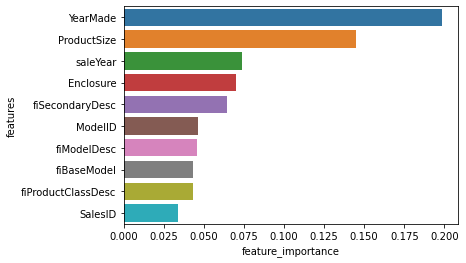

In [94]:
plot_features(X_train.columns, ideal_model.feature_importances_, 10)